In [1]:
from glob import glob
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMG_CHANNELS = 3
IMG_ROWS = 224
IMG_COLS = 224
IMG_CLASSES = 2         # mountain and sea

In [13]:
# Load dataset
def load_images_and_labels(files, label):
    images = [image.load_img(p, target_size=(IMG_ROWS, IMG_COLS)) for p in files]
    labels = [label] * len(files)
    return images, labels

mountain_files = glob('/content/drive/MyDrive/Samples/crawling/m_mountain/*jpg')
sea_files = glob('/content/drive/MyDrive/Samples/crawling/s_sea/*jpg')

mountain_images, mountain_labels = load_images_and_labels(mountain_files, 0)    # label mountain as 0
sea_images, sea_labels = load_images_and_labels(sea_files, 1)                   # label sea as 1

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (109542160 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [14]:
# Concatenate mountain dataset and sea dataset
images = mountain_images + sea_images
labels = mountain_labels + sea_labels

In [15]:
# Vectorize the images
image_vector = np.asarray([image.img_to_array(img) for img in images])

In [16]:
# Preprocess the image vectors
image_vector = preprocess_input(image_vector)

In [17]:
# Convert to categorical labels
labels = to_categorical(labels, IMG_CLASSES)

In [18]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(image_vector, labels, test_size=0.2, random_state=42)

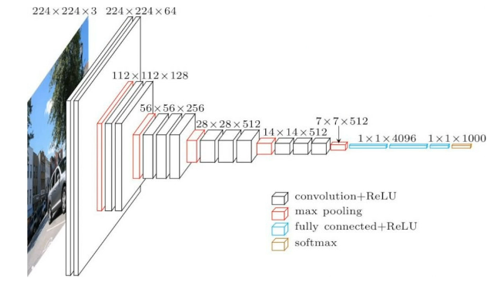

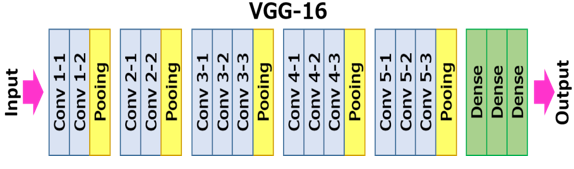

In [19]:
# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))
base_model.trainable = False    # Fix original weights
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [20]:
# Add some layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(IMG_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 6423298 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [21]:
# Compile
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=10, epochs=10, validation_split=0.2)

Epoch 1/10
24/24 [==============================] - 196s 8s/step - loss: 2.8426 - accuracy: 0.6987 - val_loss: 1.1333 - val_accuracy: 0.8500
Epoch 2/10
24/24 [==============================] - 190s 8s/step - loss: 0.6012 - accuracy: 0.9498 - val_loss: 1.0832 - val_accuracy: 0.8500
Epoch 3/10
24/24 [==============================] - 191s 8s/step - loss: 0.4037 - accuracy: 0.9749 - val_loss: 1.3522 - val_accuracy: 0.8500
Epoch 4/10
24/24 [==============================] - 196s 8s/step - loss: 0.1274 - accuracy: 0.9874 - val_loss: 1.6349 - val_accuracy: 0.8333
Epoch 5/10
24/24 [==============================] - 191s 8s/step - loss: 0.0545 - accuracy: 0.9958 - val_loss: 1.5263 - val_accuracy: 0.8333
Epoch 6/10
24/24 [==============================] - 190s 8s/step - loss: 0.0414 - accuracy: 0.9916 - val_loss: 1.4226 - val_accuracy: 0.8333
Epoch 7/10
24/24 [==============================] - 195s 8s/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 1.4895 - val_accuracy: 0.8333
Epoch 8/10
24

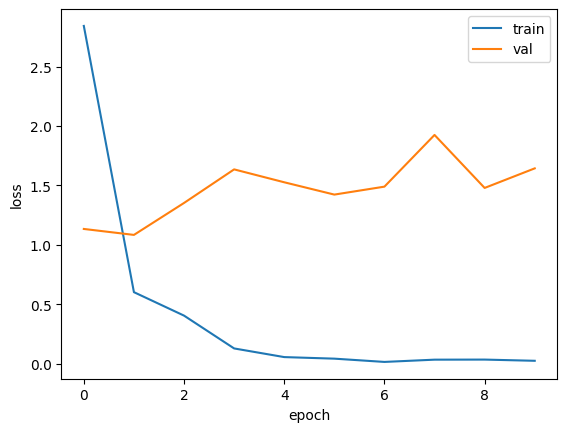

In [23]:
# Visualize loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

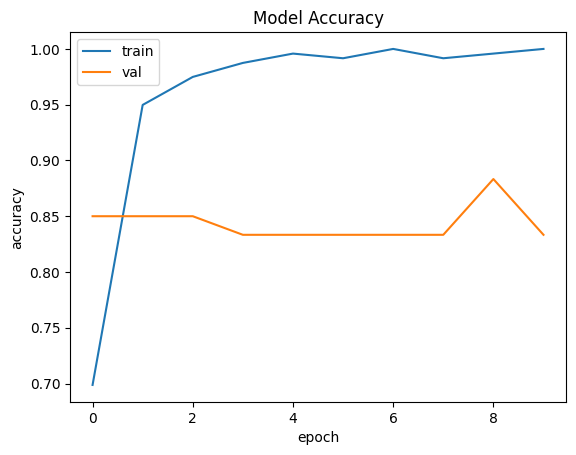

In [24]:
# Visualize accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

3/3 [==============================] - 49s 13s/step - loss: 1.7443 - accuracy: 0.8267
Test loss: 1.7443
Test accuracy: 0.8267
